In [1]:
import pickle
import numpy as np
import matplotlib.pylab as plt
import scipy.ndimage
import cv2
from Calibration.utils import *
import open3d as o3d

In [2]:
def load_background(data_dir, cam_list, depth_idx=3):
    bg_imgs = {}
    for cam in cam_list:
        bg_file = '%s/%s/depth/depth%04i.png' % (data_dir, cam, depth_idx)
        # bg_file = '%s/%s_calib_snap/depth%04i.png' % (data_dir, cam, depth_idx)
        bg_img = cv2.imread(bg_file, -1)

        # plt.figure()
        # plt.imshow(bg_img, cmap='gray')
        # plt.show()

        bg_imgs[cam] = bg_img
    return bg_imgs


def substract_foreground(bg_img, img, min_depth=500, max_depth=4000):
    bg_img = bg_img.astype(np.float32)
    img = img.astype(np.float32)

    # substraction
    img_bin = (np.abs(bg_img - img) > 60) * (img > min_depth) * (img < max_depth)
    img_bin = scipy.ndimage.median_filter(img_bin, 5)

    # connected component (useless)
    num_labels, labels_im = cv2.connectedComponents(img_bin.astype(np.uint8))
    # label 0 is the background with the largest area, second largest is the foreground
    areas = [np.sum(labels_im==(i+1)) for i in range(num_labels-1)]
    max_label = areas.index(max(areas))
    img_bin = labels_im == (max_label + 1)

    plt.figure()
    plt.imshow(img_bin, cmap='gray')
    plt.show()
    return img_bin


In [6]:
cam_list = ['azure_kinect_0', 'azure_kinect_1', 'azure_kinect_2', 'kinect_v2_1', 'kinect_v2_2']
bg_data_dir = 'D:/UoA_Research/data_2/1'
data_dir = 'D:/UoA_Research/data_8'

# load intrinsic parameters
with open('%s/intrinsic_param.pkl' % data_dir, 'rb') as f:
    intr_params = pickle.load(f)
    print(intr_params.keys())

# load intrinsic parameters
with open('%s/extrinsic_param.pkl' % data_dir, 'rb') as f:
    extr_params = pickle.load(f)
    print(extr_params.keys())

bg_imgs = load_background(bg_data_dir, cam_list, 10)


dict_keys(['azure_kinect_0_color', 'azure_kinect_0_depth', 'azure_kinect_1_color', 'azure_kinect_1_depth', 'azure_kinect_2_color', 'azure_kinect_2_depth', 'kinect_v2_1_color', 'kinect_v2_1_depth', 'kinect_v2_2_color', 'kinect_v2_2_depth', 'event_camera', 'polar'])
dict_keys(['azure_kinect_2-kinect_v2_2', 'azure_kinect_0-azure_kinect_2', 'polar-azure_kinect_0', 'event_camera-azure_kinect_0', 'azure_kinect_0-azure_kinect_1', 'azure_kinect_1-kinect_v2_1'])


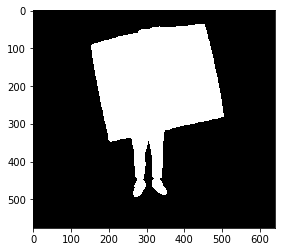

azure_kinect_0 [  46.36941973 -376.84680618 1667.79947061]
azure_kinect_1 [ -86.54401743 -246.43095128 1742.13552453]
azure_kinect_2 [ 174.7562248  -268.66051454 1720.74616075]
kinect_v2_1 [-149.86591469 -307.97543206 1796.57974661]
kinect_v2_2 [ 213.67195755 -381.38788089 1782.02772082]


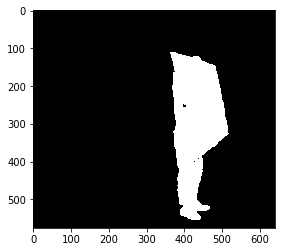

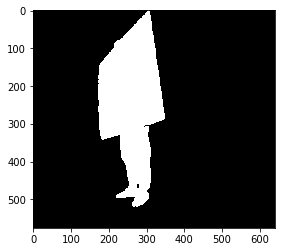

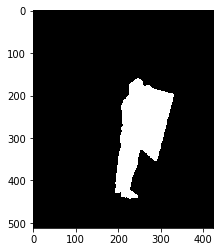

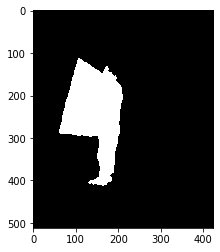

In [4]:
# frame_idx = 50
# point_clouds = {}
# trans_inits = {}
# for cam in cam_list:
#     fname = '%s/%s_calib_snap/depth%04i.png' % (data_dir, cam, frame_idx)
#     depth_img = cv2.imread(fname, -1).astype(np.float32)
#
#     img_mask = substract_foreground(bg_imgs[cam], depth_img)
#     img = depth_img * img_mask
#
#     # project to 3D space
#     uvd = depth2uvd(img).reshape([-1, 3])
#     uvd = uvd[uvd[:, 2] > 0, :]  # get the point whose depth is greater than 0
#     xyz = unprojection(uvd, intr_params['%s_depth' % cam])
#
#     # transform to azure_kinect_0
#     if cam is 'azure_kinect_0':
#         point_cloud = xyz.copy()
#         trans_init = Transform()  # default identity rotation and zero translation
#     else:
#         # [cam2-cam1] from cam1 to cam2
#         if 'azure_kinect' in cam:
#             T_cam2cam1 = Transform(r=extr_params['azure_kinect_0-%s' % cam][0],
#                                    t=extr_params['azure_kinect_0-%s' % cam][1])
#             trans_init = T_cam2cam1
#         elif cam is 'kinect_v2_1':
#             T_cam2cam1 = Transform(r=extr_params['azure_kinect_1-kinect_v2_1'][0],
#                                    t=extr_params['azure_kinect_1-kinect_v2_1'][1])
#             T_cam3cam2 = Transform(r=extr_params['azure_kinect_0-azure_kinect_1'][0],
#                                    t=extr_params['azure_kinect_0-azure_kinect_1'][1])
#             trans_init = T_cam3cam2 * T_cam2cam1
#         else:
#             # 'kinect_v2_2'
#             T_cam2cam1 = Transform(r=extr_params['azure_kinect_2-kinect_v2_2'][0],
#                                    t=extr_params['azure_kinect_2-kinect_v2_2'][1])
#             T_cam3cam2 = Transform(r=extr_params['azure_kinect_0-azure_kinect_2'][0],
#                                    t=extr_params['azure_kinect_0-azure_kinect_2'][1])
#             trans_init = T_cam3cam2 * T_cam2cam1
#         point_cloud = trans_init.transform(xyz)
#         point_cloud = point_cloud[point_cloud[:, 2] < 4000, :]
#     print(cam, np.mean(point_cloud, axis=0))
#     point_clouds[cam] = point_cloud
#     trans_inits[cam] = trans_init



In [12]:
# target = o3d.geometry.PointCloud()
# target.points = o3d.utility.Vector3dVector(point_clouds['azure_kinect_0'])
# # voxel_target = target.voxel_down_sample(voxel_size=0.05)
# target.paint_uniform_color([0, 0.651, 0.929])
#
# source = o3d.geometry.PointCloud()
# source.points = o3d.utility.Vector3dVector(point_clouds['azure_kinect_2'])
# # voxel_source = source.voxel_down_sample(voxel_size=0.05)
# source.paint_uniform_color([1, 0.706, 0])
#
#
# # o3d.visualization.draw_geometries([voxel_target, voxel_source])
# o3d.visualization.draw_geometries([target, source])


RuntimeError: [Open3D ERROR] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 

In [18]:
# target = o3d.geometry.PointCloud()
# target.points = o3d.utility.Vector3dVector(point_clouds['azure_kinect_0'])
# # voxel_target = target.voxel_down_sample(voxel_size=0.05)
# target.paint_uniform_color([0, 0.651, 0.929])
#
# source = o3d.geometry.PointCloud()
# source.points = o3d.utility.Vector3dVector(point_clouds['kinect_v2_1'])
# # voxel_source = source.voxel_down_sample(voxel_size=0.05)
# source.paint_uniform_color([1, 0.706, 0])
#
#
# # o3d.visualization.draw_geometries([voxel_target, voxel_source])
# o3d.visualization.draw_geometries([target, source])


RuntimeError: [Open3D ERROR] GLFW Error: WGL: Failed to make context current: The handle is invalid. 

In [7]:
def get_tranform_mtx(r, t):
    T = np.zeros([4, 4])
    T[0:3, 0:3] = r
    T[0:3, 3] = np.squeeze(t)
    T[3, 3] = 1
    return T

def get_homo_point(xyz):
    assert xyz.shape[1] == 3
    one_array = np.ones([xyz.shape[0], 1])
    xyz_homo = np.concatenate([xyz, one_array], axis=1)
    return xyz_homo

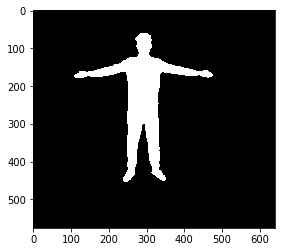

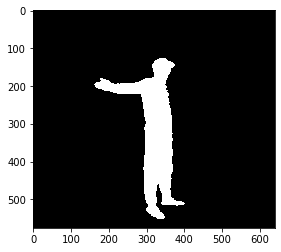

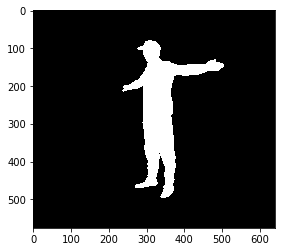

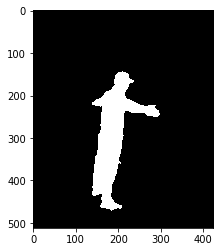

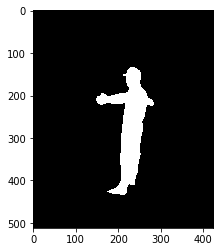

In [17]:
frame_idx = 121
pcds = []
trans_inits = []
# ['azure_kinect_0', 'azure_kinect_1', 'azure_kinect_2', 'kinect_v2_1', 'kinect_v2_2']
for cam in cam_list:
    fname = '%s/%s_calib_snap/depth%04i.png' % (data_dir, cam, frame_idx)
    depth_img = cv2.imread(fname, -1).astype(np.float32)

    img_mask = substract_foreground(bg_imgs[cam], depth_img)
    img = depth_img * img_mask

    # project to 3D space
    uvd = depth2uvd(img).reshape([-1, 3])
    uvd = uvd[uvd[:, 2] > 0, :]  # get the point whose depth is greater than 0
    uvd = uvd[uvd[:, 2] < 4000, :]
    xyz = unprojection(uvd, intr_params['%s_depth' % cam])

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=30, max_nn=30))
    pcds.append(pcd)

In [10]:
# aggregate transformation matrix
print(cam_list[0], np.mean(np.asarray(pcds[0].points), axis=0))

# from cam2 to cam1
T_cam1cam2 = get_tranform_mtx(extr_params['azure_kinect_0-azure_kinect_1'][0],
                              extr_params['azure_kinect_0-azure_kinect_1'][1])
pts = get_homo_point(np.asarray(pcds[1].points))
pts = np.dot(T_cam1cam2, pts.T).T
print(cam_list[1], np.mean(pts[:, 0:3], axis=0))

# from cam3 to cam1
T_cam1cam3 = get_tranform_mtx(extr_params['azure_kinect_0-azure_kinect_2'][0],
                              extr_params['azure_kinect_0-azure_kinect_2'][1])
pts = get_homo_point(np.asarray(pcds[2].points))
pts = np.dot(T_cam1cam3, pts.T).T
print(cam_list[2], np.mean(pts[:, 0:3], axis=0))

# from cam4 to cam2
T_cam2cam4 = get_tranform_mtx(extr_params['azure_kinect_1-kinect_v2_1'][0],
                              extr_params['azure_kinect_1-kinect_v2_1'][1])
T_cam1cam4 = np.dot(T_cam1cam2, T_cam2cam4)
pts = get_homo_point(np.asarray(pcds[3].points))
pts = np.dot(T_cam1cam2, np.dot(T_cam2cam4, pts.T)).T
print(cam_list[3], np.mean(pts[:, 0:3], axis=0))

# from cam5 to cam3
T_cam3cam5 = get_tranform_mtx(extr_params['azure_kinect_2-kinect_v2_2'][0],
                              extr_params['azure_kinect_2-kinect_v2_2'][1])
T_cam1cam5 = np.dot(T_cam1cam3, T_cam3cam5)
pts = get_homo_point(np.asarray(pcds[4].points))
pts = np.dot(T_cam1cam3, np.dot(T_cam3cam5, pts.T)).T
print(cam_list[4], np.mean(pts[:, 0:3], axis=0))

azure_kinect_0 [ -86.46805704 -364.53336044 2153.62129384]
azure_kinect_1 [-227.26035137 -276.34556559 2181.41523706]
azure_kinect_2 [  11.91609825 -315.44704742 2190.6621321 ]
kinect_v2_1 [-240.93149886 -325.63077489 2246.56884721]
kinect_v2_2 [  50.9061553  -358.14629386 2267.81345635]


In [18]:
def multiway_registration(source_id, target_id, trans_init, pcds,
                          uncertain, max_correspondence_distance_fine):
    source = pcds[source_id]
    target = pcds[target_id]
    icp_fine = o3d.registration.registration_icp(
        source, target, max_correspondence_distance_fine,
        trans_init, o3d.registration.TransformationEstimationPointToPlane())
    transformation_icp = icp_fine.transformation
    information_icp = o3d.registration.get_information_matrix_from_point_clouds(
        source, target, max_correspondence_distance_fine, icp_fine.transformation)

    if not uncertain:
        return o3d.registration.PoseGraphEdge(source_id, target_id, transformation_icp,
                                              information_icp, uncertain=False)
    else:
        return o3d.registration.PoseGraphEdge(source_id, target_id, transformation_icp,
                                              information_icp, uncertain=True)

with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    max_correspondence_distance_fine = 30  # millimeters
    pose_graph = o3d.registration.PoseGraph()
    pose_graph.nodes.append(o3d.registration.PoseGraphNode(np.identity(4)))  # node cam1

    # PoseGraphNode(<transform from the appended node to the root node>)
    pose_graph.nodes.append(o3d.registration.PoseGraphNode(T_cam1cam2))  # node cam2
    pose_graph.nodes.append(o3d.registration.PoseGraphNode(T_cam1cam3))  # node cam3
    pose_graph.nodes.append(o3d.registration.PoseGraphNode(T_cam1cam4))  # node cam4
    pose_graph.nodes.append(o3d.registration.PoseGraphNode(T_cam1cam5))  # node cam5

    # PoseGraphEdge
    pose_graph.edges.append(
        multiway_registration(1, 0, T_cam1cam2, pcds, False, max_correspondence_distance_fine))
    pose_graph.edges.append(
        multiway_registration(2, 0, T_cam1cam3, pcds, False, max_correspondence_distance_fine))
    pose_graph.edges.append(
        multiway_registration(4, 2, T_cam3cam5, pcds, False, max_correspondence_distance_fine))
    pose_graph.edges.append(
        multiway_registration(3, 1, T_cam2cam4, pcds, False, max_correspondence_distance_fine))


    pose_graph.edges.append(
        multiway_registration(4, 0, T_cam1cam5, pcds, True, max_correspondence_distance_fine))
    pose_graph.edges.append(
        multiway_registration(3, 0, T_cam1cam4, pcds, True, max_correspondence_distance_fine))

    # T_cam2cam3 = np.dot(np.linalg.inv(T_cam1cam2), T_cam1cam3)
    # pose_graph.edges.append(
    #     multiway_registration(2, 1, T_cam2cam3, pcds, True, max_correspondence_distance_fine))
    # T_cam2cam5 = np.dot(np.linalg.inv(T_cam1cam2), T_cam1cam5)
    # pose_graph.edges.append(
    #     multiway_registration(4, 1, T_cam2cam5, pcds, True, max_correspondence_distance_fine))
    # T_cam3cam4 = np.dot(np.linalg.inv(T_cam1cam3), T_cam1cam4)
    # pose_graph.edges.append(
    #     multiway_registration(3, 2, T_cam3cam4, pcds, True, max_correspondence_distance_fine))
    T_cam4cam5 = np.dot(np.linalg.inv(T_cam1cam4), T_cam1cam5)
    pose_graph.edges.append(
        multiway_registration(4, 3, T_cam4cam5, pcds, True, max_correspondence_distance_fine))

option = o3d.registration.GlobalOptimizationOption(
    max_correspondence_distance=max_correspondence_distance_fine,
    edge_prune_threshold=0.25,
    reference_node=0)
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as optim:
    o3d.registration.global_optimization(
        pose_graph, o3d.registration.GlobalOptimizationLevenbergMarquardt(),
        o3d.registration.GlobalOptimizationConvergenceCriteria(), option)


[Open3D DEBUG] ICP Iteration #0: Fitness 0.8208, RMSE 10.4251
[Open3D DEBUG] Residual : 7.38e+01 (# of elements : 24930)
[Open3D DEBUG] ICP Iteration #1: Fitness 0.8200, RMSE 9.2962
[Open3D DEBUG] Residual : 4.56e+01 (# of elements : 24907)
[Open3D DEBUG] ICP Iteration #2: Fitness 0.8162, RMSE 9.1623
[Open3D DEBUG] Residual : 4.18e+01 (# of elements : 24792)
[Open3D DEBUG] ICP Iteration #3: Fitness 0.8151, RMSE 9.1477
[Open3D DEBUG] Residual : 4.14e+01 (# of elements : 24757)
[Open3D DEBUG] ICP Iteration #4: Fitness 0.8148, RMSE 9.1449
[Open3D DEBUG] Residual : 4.13e+01 (# of elements : 24750)
[Open3D DEBUG] ICP Iteration #5: Fitness 0.8147, RMSE 9.1423
[Open3D DEBUG] Residual : 4.13e+01 (# of elements : 24746)
[Open3D DEBUG] ICP Iteration #6: Fitness 0.8147, RMSE 9.1429
[Open3D DEBUG] Residual : 4.13e+01 (# of elements : 24746)
[Open3D DEBUG] ICP Iteration #7: Fitness 0.8147, RMSE 9.1433
[Open3D DEBUG] Residual : 4.13e+01 (# of elements : 24746)
[Open3D DEBUG] ICP Iteration #8: Fitnes

In [19]:
T_list = [np.identity(4), T_cam1cam2, T_cam1cam3, T_cam1cam4, T_cam1cam5]
pts_prior_list = []
pts_poster_list = []
for idx in range(5):
    print('-----------------------------------------------------------')
    pts = get_homo_point(np.asarray(pcds[idx].points))

    print(T_list[idx])
    pts_prior = np.dot(T_list[idx], pts.T).T[:, 0:3]
    pts_prior_list.append(pts_prior)

    print(pose_graph.nodes[idx].pose)
    trans = pose_graph.nodes[idx].pose
    pts_poster = np.dot(trans, pts.T).T[:, 0:3]
    pts_poster_list.append(pts_poster)

pts_prior = np.concatenate(pts_prior_list, axis=0)
pts_poster = np.concatenate(pts_poster_list, axis=0)

pcd_prior = o3d.geometry.PointCloud()
pcd_prior.points = o3d.utility.Vector3dVector(pts_prior)
_, ind = pcd_prior.remove_radius_outlier(nb_points=30, radius=100)
pcd_prior = pcd_prior.select_by_index(ind)

pcd_poster = o3d.geometry.PointCloud()
pcd_poster.points = o3d.utility.Vector3dVector(pts_poster)
_, ind = pcd_poster.remove_radius_outlier(nb_points=30, radius=100)
pcd_poster = pcd_poster.select_by_index(ind)

-----------------------------------------------------------
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[ 1.00000000e+00  1.20278679e-19  0.00000000e+00  1.77635684e-15]
 [ 1.23666810e-19  1.00000000e+00  8.67361738e-19 -1.77635684e-15]
 [ 4.33680869e-19  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
-----------------------------------------------------------
[[ 6.62834124e-01 -2.31605716e-02  7.48407985e-01 -1.75058045e+03]
 [ 1.91704091e-01  9.71456382e-01 -1.39721289e-01  3.41393495e+01]
 [-7.23809688e-01  2.36084911e-01  6.48354417e-01  9.31068546e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 6.70770839e-01 -1.75204575e-02  7.41457697e-01 -1.75307621e+03]
 [ 1.90895883e-01  9.70116873e-01 -1.49773211e-01  5.72077476e+01]
 [-7.16676527e-01  2.42004724e-01  6.54070692e-01  9.21163625e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
------------

In [20]:
o3d.io.write_point_cloud("%s/prior.ply" % data_dir, pcd_prior)
o3d.io.write_point_cloud("%s/poster.ply" % data_dir, pcd_poster)

True

In [ ]:
pcd_prior.paint_uniform_color([0, 0.651, 0.929]) # blue
pcd_poster.paint_uniform_color([1, 0.706, 0])  # orange


In [60]:
o3d.visualization.draw_geometries([pcd_prior, pcd_poster])

In [13]:
o3d.visualization.draw_geometries([pcd_prior])


RuntimeError: [Open3D ERROR] GLFW Error: WGL: Failed to make context current: The handle is invalid. 

In [31]:
o3d.visualization.draw_geometries([pcd_poster])


RuntimeError: [Open3D ERROR] GLFW Error: WGL: Failed to make context current: The handle is invalid. 

In [44]:
downpcd = pcd_poster.voxel_down_sample(voxel_size=15)

In [45]:
o3d.visualization.draw_geometries([downpcd])


RuntimeError: [Open3D ERROR] GLFW Error: WGL: Failed to make context current: The handle is invalid. 

In [25]:
downpcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=30, max_nn=30))

RuntimeError: [Open3D ERROR] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 

In [ ]:
o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

